In [ ]:
!pip install deepxde

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.9/165.9 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 9.2 MB/s eta 0:00:00


In [ ]:
from deepxde.backend.set_default_backend import set_default_backend
set_default_backend("tensorflow")

No backend selected.
Finding available backend...


Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.
Instructions for updating:
non-resource variables are not supported in the long term


Found tensorflow.compat.v1
Setting the default backend to "tensorflow.compat.v1". You can change it in the ~/.deepxde/config.json file or export the DDE_BACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle (all lowercase)
Setting the default backend to "tensorflow". You can change it in the ~/.deepxde/config.json file or export the DDE_BACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle (all lowercase)


In [ ]:
import deepxde as dde
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
N = norm.cdf

In [ ]:
from deepxde.backend import tf

In [ ]:
def pde(x, y):
  K, sigma, r = 4, 0.3, 0.03
  dy_t = dde.grad.jacobian(y, x, i=0, j=1)
  dy_x = dde.grad.jacobian(y, x, i=0, j=0)
  dy_xx = dde.grad.hessian(y, x, i=0, j=0)
  return dy_t - ((sigma**2 * tf.math.square(x[:,0:1])) / 2) * dy_xx - r * x[:,0:1] * dy_x + r * y

def payoff_func(x):
  return np.maximum(4 - x[:, 0:1], 0)

def func(x):
  temp = K * np.exp(-r * x[:, 1:2])
  return temp

def func_r(x):
  return 0;

def boundary_l(x, on_boundary):
  return on_boundary and dde.utils.isclose(x[0], 0)

def boundary_r(x, on_boundary):
  return dde.utils.isclose(x[0], 10)

def bs_eq_exact_solution(x, t):
  """Returns the exact solution for a given x and t (for sinusoidal initial conditions).

  Parameters
  ----------
    x : np.ndarray
    t : np.ndarray
  """
  d1 = (np.log(x/K) + (r + sigma**2/2)*t) / (sigma*np.sqrt(t))
  d2 = d1 - sigma* np.sqrt(t)
  return K * np.exp(-r*t) * N(-d2) - x * N(-d1)

def gen_exact_solution():
  """Generates exact solution for the heat equation for the given values of x and t."""
  # Number of points in each dimension:
  x_dim, t_dim = (256, 500)

  # Bounds of 'x' and 't':
  x_min, t_min = (0, 0.0)
  x_max, t_max = (L, 1.0)

  # Create tensors:
  t = np.linspace(t_min, t_max, num=t_dim).reshape(t_dim, 1)
  x = np.linspace(x_min, x_max, num=x_dim).reshape(x_dim, 1)
  usol = np.zeros((x_dim, t_dim)).reshape(x_dim, t_dim)

  # Obtain the value of the exact solution for each generated point:
  for i in range(x_dim):
    for j in range(t_dim):
      usol[i][j] = bs_eq_exact_solution(x[i], t[j])

  # Save solution:
  np.savez("bs_eq_data", x=x, t=t, usol=usol)

def gen_testdata():
  """Import and preprocess the dataset with the exact solution."""
  # Load the data:
  data = np.load("bs_eq_data.npz")
  # Obtain the values for t, x, and the excat solution:
  t, x, exact = data["t"], data["x"], data["usol"].T
  # Process the data and flatten it out (like labels and features):
  xx, tt = np.meshgrid(x, t)
  X = np.vstack((np.ravel(xx), np.ravel(tt))).T
  y = exact.flatten()[:, None]
  print(f'Shape of X: {X.shape}\nShape of y: {y.shape}\n')
  return X, y

In [ ]:
# Problem Parameters
K = 4
L = 10
T = 1
sigma = 0.3
r = 0.03

In [ ]:
gen_exact_solution()

<ipython-input-5-ef8d99f0482b>:32: RuntimeWarning: divide by zero encountered in log
  d1 = (np.log(x/K) + (r + sigma**2/2)*t) / (sigma*np.sqrt(t))
<ipython-input-5-ef8d99f0482b>:32: RuntimeWarning: divide by zero encountered in divide
  d1 = (np.log(x/K) + (r + sigma**2/2)*t) / (sigma*np.sqrt(t))
<ipython-input-5-ef8d99f0482b>:32: RuntimeWarning: invalid value encountered in divide
  d1 = (np.log(x/K) + (r + sigma**2/2)*t) / (sigma*np.sqrt(t))


In [ ]:
temp = np.arange(1,10,1).reshape(9, 1)
print(temp.shape)
np.maximum(4 - temp[:,0:1], 2).shape

(9, 1)


(9, 1)

In [ ]:
# Computational geometry:
geom = dde.geometry.Interval(0, 10)
timedomain = dde.geometry.TimeDomain(0, 1)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

# Initial and boundary conditions:
ic = dde.icbc.IC(
    geomtime,
    payoff_func,
    lambda _, on_initial: on_initial,
)

bc_l = dde.icbc.boundary_conditions.DirichletBC(geom, func, boundary_l)
bc_r = dde.icbc.boundary_conditions.DirichletBC(geom, func_r, boundary_r)
# bc_l = dde.icbc.boundary_conditions.OperatorBC(geom, )

In [ ]:
# Define the PDE problem and configurations of the network:
data = dde.data.TimePDE(
    geomtime,
    pde,
    [bc_r, bc_l, ic],
    num_domain=5080,
    num_boundary=160,
    num_initial=320,
    num_test=5000,
)

In [ ]:
net = dde.nn.FNN([2] + [30] * 5 + [1], "tanh", "Glorot normal")
model = dde.Model(data, net)

In [ ]:
# Build and train the model:
model.compile("adam", lr=0.001)
model.train(iterations=100)

Compiling model...
Building feed-forward neural network...
'build' took 0.152969 s



/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 1.192950 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [1.84e-02, 6.86e-02, 1.61e+01, 2.02e+00]    [1.86e-02, 6.86e-02, 1.61e+01, 2.02e+00]    []  
100       [1.39e-02, 2.21e-03, 5.36e-03, 3.59e-02]    [6.83e-03, 2.21e-03, 5.36e-03, 3.59e-02]    []  

Best model at step 100:
  train loss: 5.74e-02
  test loss: 5.03e-02
  test metric: []

'train' took 5.247409 s



(<deepxde.model.LossHistory at 0x785fde3dd510>,
 <deepxde.model.TrainState at 0x785fde3dd750>)

In [ ]:
model.compile("L-BFGS")
losshistory, train_state = model.train()

Compiling model...
'compile' took 0.581072 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
100       [1.39e-02, 2.21e-03, 5.36e-03, 3.59e-02]    [6.83e-03, 2.21e-03, 5.36e-03, 3.59e-02]    []  
1000      [1.35e-04, 1.98e-06, 1.51e-07, 2.61e-04]    [1.35e-04, 1.98e-06, 1.51e-07, 2.61e-04]        
2000      [8.36e-05, 2.93e-07, 1.64e-07, 1.21e-04]    [8.36e-05, 2.93e-07, 1.64e-07, 1.21e-04]        
3000      [3.65e-05, 3.91e-07, 1.01e-07, 6.47e-05]    [3.65e-05, 3.91e-07, 1.01e-07, 6.47e-05]        
4000      [1.94e-05, 8.27e-08, 1.68e-07, 3.81e-05]    [1.94e-05, 8.27e-08, 1.68e-07, 3.81e-05]        
5000      [1.31e-05, 2.58e-08, 9.17e-09, 2.22e-05]    [1.31e-05, 2.58e-08, 9.17e-09, 2.22e-05]        
5343      [1.13e-05, 3.69e-08, 1.48e-08, 2.01e-05]    [9.58e-06, 3.69e-08, 1.48e-08, 2.01e-05]    []  

Best model at step 5343:
  train loss: 3.14e-05
  test loss: 2.97e-05
  test metric: []

'train' took 2

Saving loss history to /content/loss.dat ...
Saving training data to /content/train.dat ...
Saving test data to /content/test.dat ...


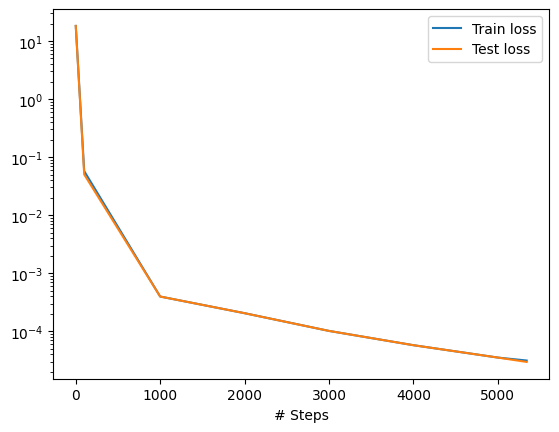

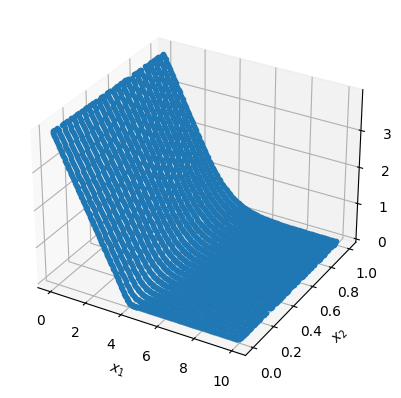

In [ ]:
dde.saveplot(losshistory, train_state, issave=True, isplot=True)

In [ ]:
X, y_true = gen_testdata()
y_pred = model.predict(X)
f = model.predict(X, operator=pde)
print("Mean residual:", np.mean(np.absolute(f)))
print("L2 relative error:", dde.metrics.l2_relative_error(y_true, y_pred))
np.savetxt("test.dat", np.hstack((X, y_true, y_pred)))

Shape of X: (128000, 2)
Shape of y: (128000, 1)

Mean residual: 0.0018907416
L2 relative error: nan


In [ ]:
# np.savez("for_plotting", x=X, y=y_true, y_pred=y_pred)

In [ ]:
temp = np.linspace(0, 10, 128000)

In [ ]:
temp[:,None].shape

(128000, 1)

In [ ]:
temp = []
final_index = np.array(temp, dtype=np.int32)
for i in range(0, X.shape[0]):
  if(X[i,1] == 1):
    final_index = np.append(final_index, i)

final_index.shape

(256,)

<function matplotlib.pyplot.show(close=None, block=None)>

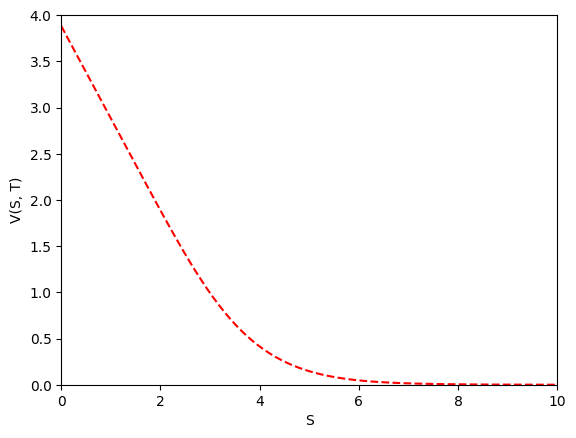

In [ ]:
plt.plot(X[final_index, 0], y_pred[final_index], '--', color="r")

# plt.figure()
plt.xlabel('S')
plt.ylabel('V(S, T)')
# set the limits
plt.xlim([0, 10])
plt.ylim([0, 4])
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

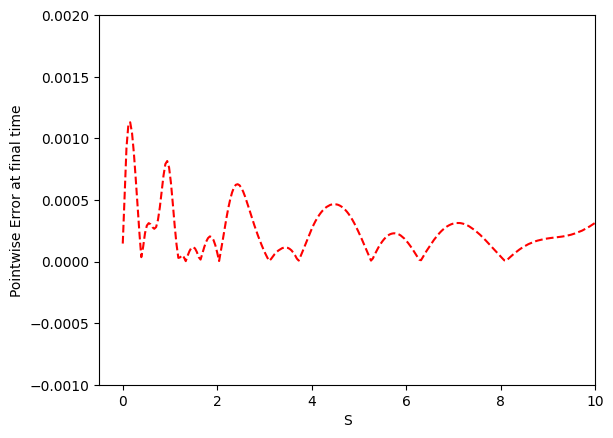

In [ ]:
plt.plot(X[final_index, 0], np.abs(y_pred[final_index] - y_true[final_index]), '--', color="r")

# plt.figure()
plt.xlabel('S')
plt.ylabel('Pointwise Error at final time')
# set the limits
plt.xlim([-0.5, 10])
plt.ylim([-0.001, 0.002])
plt.show

In [ ]:
max(abs(y_true[final_index] - y_pred[final_index]))

array([0.00113041])